In [1]:
from phase_scrambled_corr.phase_scrambled_corr import * 
from phase_scrambled_corr.example_time_series import * 

import numpy as np 
import matplotlib.pyplot as plt

### 1. Generate AR1 timeseries. These are randomly generated and so they shouldn't be significantly correlated

In [2]:
N = 250               # number of time points
dt = 1.0              # time step = 1 month
fs = 1 / dt           # sampling frequenct = 1 / 1 month

# AR(1) parameters
rho_x = 0.9
rho_y = 0.9
noise_std = 1.0

# Preallocate arrays
t, x = AR1_simulate(rho_x, noise_std, 1, N, seed = 42)
t, y = AR1_simulate(rho_y, noise_std, 1, N, seed = 31)

ccf_maxlag = 36
lags, ccf, gauss_pvals = cross_correlation(x, y, dt=1.0, maxlags=ccf_maxlag)
lag_max, ccf_max = cross_correlation_maxima(x, y, dt=1.0, maxlags=ccf_maxlag)

### 2. Visualize AR1 timeseries and their cross correlation

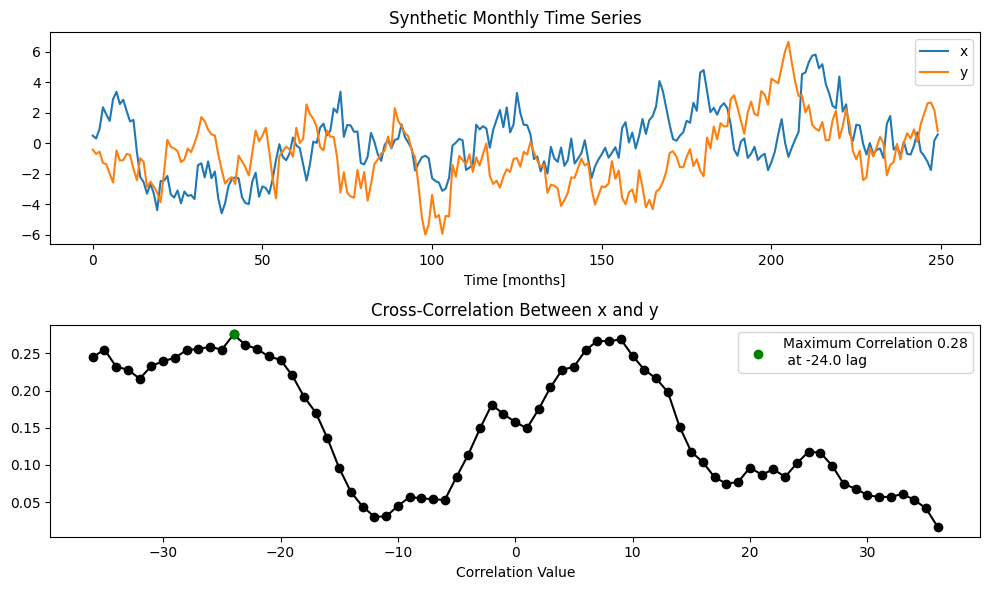

In [3]:
# Plot observed time series
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].plot(t, x, label='x')
axes[0].plot(t, y, label='y')
axes[0].set_title('Synthetic Monthly Time Series')
axes[0].set_xlabel('Time [months]')
axes[0].legend()

axes[1].plot(lags, ccf, c = "k", marker = "o", zorder = 1)
axes[1].scatter(lag_max, ccf_max, c = "green", marker = "o", zorder = 2, 
                label = f"Maximum Correlation {np.round(ccf_max, decimals = 2)}\n at {lag_max} lag")

axes[1].set_title('Cross-Correlation Between x and y')
axes[1].set_xlabel('Lag [months]')
axes[1].set_xlabel('Correlation Value')
axes[1].legend()
fig.tight_layout()

### 3. Check correlation significance using two different methods

In [4]:
def plot_significant_correlations(ax, lags, ccf, pvals, alpha=0.05):
    """
    Scatter plot of cross-correlation coefficients, coloring points red if
    their p-value is below `alpha` and black otherwise.
    """
    # Determine colors based on significance threshold
    colors = ['r' if p < alpha else 'k' for p in pvals]
    ax.plot(lags, ccf, c="k", zorder=0)
    ax.scatter(lags, ccf, c=colors, marker='o', zorder=2)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Significance (alpha={alpha})')
    ax.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Significant', markerfacecolor='r', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Not Significant', markerfacecolor='k', markersize=8)
    ], loc='best')
    return ax


Text(0, 0.5, '')

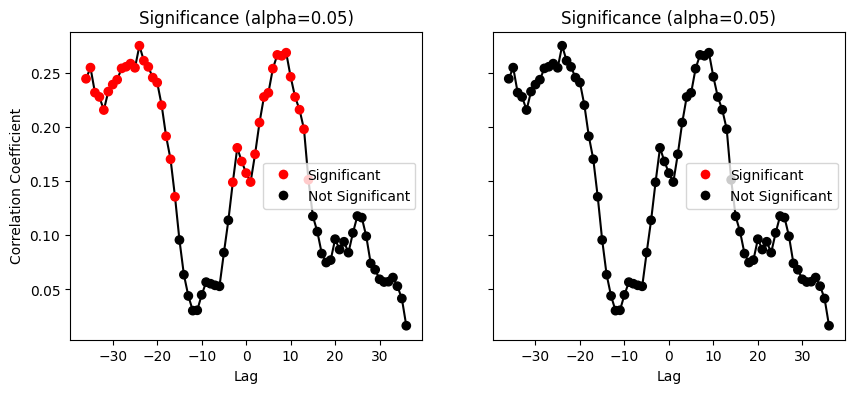

In [5]:
#### BOOTSTRAPPED (MONTE CARLO) CCF SIGNIFICANCE #####
n_iter = 5000 #number of Monte Carlo Iterations 
lags, ccf, bootpvals = bootstrapped_cross_correlation(x, y, dt=dt, maxlags=ccf_maxlag, 
                                   n_iter = n_iter, return_distributions = False, remove_mean = True)
#### GAUSSIAN CCF SIGNIFICANCE #####
lags, ccf, gauss_pvals = cross_correlation(x, y, dt=dt, maxlags=ccf_maxlag)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey = True)

axes[0].set_title("Cross Correlation Significance using Gaussian Assumption")
plot_significant_correlations(axes[0], lags, ccf, gauss_pvals, alpha=0.05)

axes[1].set_title("Cross Correlation Significance using Phase Scrambling")
plot_significant_correlations(axes[1], lags, ccf, bootpvals, alpha=0.05)
axes[1].set_ylabel("")
